In [1]:
!pip install bottleneck

In [2]:
import xarray as xr
import numpy as np
import bottleneck as bn

In [3]:
# open datasets
ds_1 = xr.open_dataset('ecosg_height_final_map_1km.nc')
ds_2 = xr.open_dataset('ecosg_built_final_map_1km.nc')

In [4]:
# rename variables
ds_1 = ds_1.rename_vars({'lai_lv':'height'})
ds_2 = ds_2.rename_vars({'lai_lv':'built'})

In [5]:
# define two-degree wide latitude bins
lat = np.arange(43,51+0.01,0.1)
lon = np.arange(4, 12+0.01, 0.1)
# group according to those bins and take the mean
ds_latbins = ds_1.height.groupby_bins('lat', lat).mean().to_dataset()
ds_bins_1 = ds_latbins.height.groupby_bins('lon', lon).mean().to_dataset()

In [6]:
# define two-degree wide latitude bins
lat = np.arange(43,51+0.01,0.1)
lon = np.arange(4, 12+0.01, 0.1)
# group according to those bins and take the mean
ds_latbins = ds_2.built.groupby_bins('lat', lat).mean().to_dataset()
ds_bins_2 = ds_latbins.built.groupby_bins('lon', lon).mean().to_dataset()

In [7]:
ds_1 = ds_bins_1.rename({'lon_bins': 'lon','lat_bins': 'lat'})
ds_2 = ds_bins_2.rename({'lon_bins': 'lon','lat_bins': 'lat'})

In [8]:
aoi = ds_1.merge(ds_2)

In [9]:
aoi.data_vars

Data variables:
    height   (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.2199 1.181 0.9221
    built    (time, lat, lon) float32 0.0 0.0 0.0 ... 0.009028 0.03831 0.02334

In [10]:
aoi.height.attrs['units'] = 'm'
aoi.height.attrs['long_name'] = 'Average height'

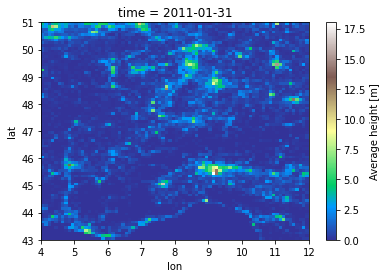

In [11]:
aoi.height.plot(cmap='terrain')

In [12]:
aoi.built.attrs['units'] = ''
aoi.built.attrs['long_name'] = 'Urban fraction'

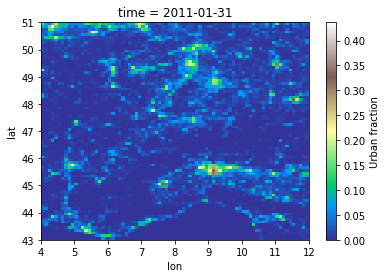

In [13]:
aoi.built.plot(cmap='terrain')

In [14]:
emissions = xr.open_dataset('MAY_2019_NOX.nc')

In [15]:
emissions

<xarray.Dataset>
Dimensions:         (latitude: 1800, longitude: 3600, time: 30)
Coordinates:
  * longitude       (longitude) float32 0.0 0.1 0.2 0.3 ... 359.7 359.8 359.9
  * latitude        (latitude) float32 -89.95 -89.85 -89.75 ... 89.85 89.95
  * time            (time) datetime64[ns] 2019-05-01 2019-05-02 ... 2019-05-30
Data variables:
    EMISSIONS_2019  (time, latitude, longitude) float32 ...

In [16]:
# define two-degree wide latitude bins
lat = np.arange(43,51+0.01,0.1)
lon = np.arange(4, 12+0.01, 0.1)
# group according to those bins and take the mean
ds_latbins = emissions.EMISSIONS_2019.groupby_bins('latitude', lat).mean().to_dataset()
aoi_emissions = ds_latbins.EMISSIONS_2019.groupby_bins('longitude', lon).mean().to_dataset()

In [17]:
#filling the few missing data
aoi_emissions['EMISSIONS_2019'] = aoi_emissions.EMISSIONS_2019.ffill('latitude_bins')
aoi_emissions['EMISSIONS_2019'] = aoi_emissions.EMISSIONS_2019.ffill('longitude_bins')

In [18]:
#rename coordinates and variables
aoi_emissions = aoi_emissions.rename({'longitude_bins': 'lon','latitude_bins': 'lat'})
aoi_emissions = aoi_emissions.rename_vars({'EMISSIONS_2019':'NO emissions'})

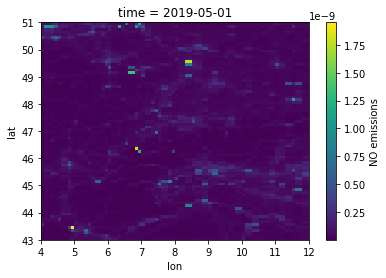

In [19]:
#plot emissions for a selected time frame
aoi_emissions['NO emissions'].isel(time=0).plot()

In [20]:
#create unique dataset
ds_emissions = aoi.merge(aoi_emissions)

In [21]:
#fill NaN with land data
ds_emissions['height'] = ds_emissions.height.ffill('time')
ds_emissions['built'] = ds_emissions.built.ffill('time')

In [22]:
ds_emissions = ds_emissions.drop_isel(time=0)

In [23]:
dataframe_togheter = ds_emissions.to_dataframe()

In [24]:
#Normalization
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

scaler = MinMaxScaler()

dataframe_norm =  pd.DataFrame(scaler.fit_transform(dataframe_togheter), columns=dataframe_togheter.columns)

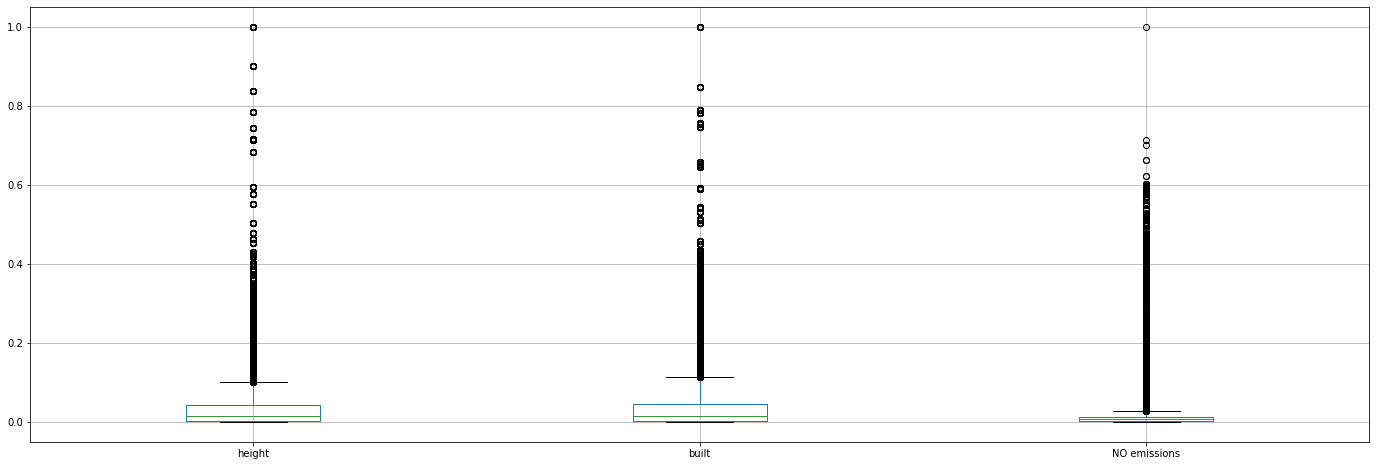

In [25]:
dataframe_norm.boxplot(figsize=(24,8));

/opt/conda/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(3.5, -0.5)

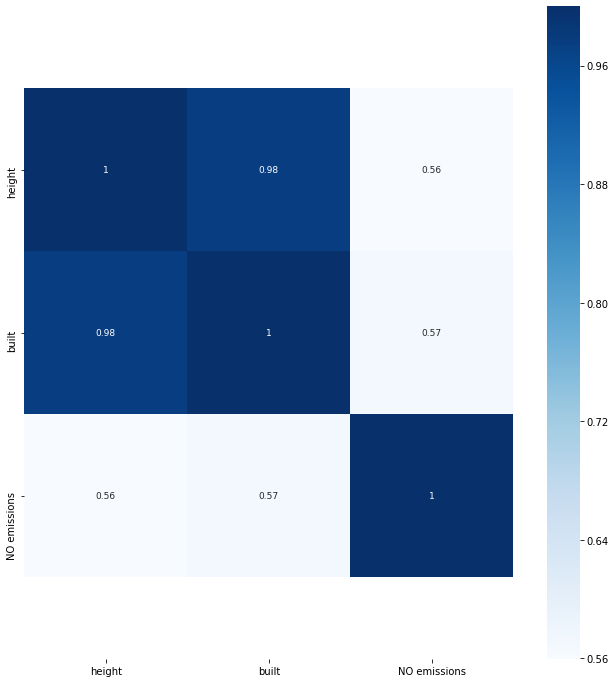

In [26]:
#Plotting results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 12));
cov=dataframe_norm.corr(method='pearson')
sns.heatmap(cov,square=True,annot=True,cmap="Blues",annot_kws={"size": 9});
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

<Figure size 1080x1080 with 0 Axes>

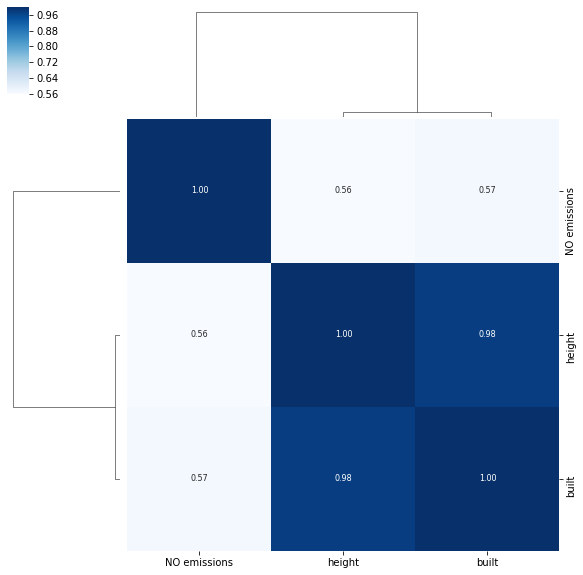

In [27]:
plt.figure(figsize=(15, 15));
sns.clustermap(cov,square=True,annot=True,cmap="Blues",annot_kws={"size": 8},fmt='.2f');

In [28]:
ds_emissions['NO emissions'].attrs['units']='kg m-2 s-1'

In [29]:
ds_emissions

<xarray.Dataset>
Dimensions:       (lat: 80, lon: 80, time: 30)
Coordinates:
  * time          (time) datetime64[ns] 2019-05-01 2019-05-02 ... 2019-05-30
  * lon           (lon) object (4.0, 4.1] (4.1, 4.2] ... (11.9, 12.0]
  * lat           (lat) object (43.0, 43.1] (43.1, 43.2] ... (50.9, 51.0]
Data variables:
    height        (time, lat, lon) float32 0.0 0.0 0.0 ... 0.2199 1.181 0.9221
    built         (time, lat, lon) float32 0.0 0.0 0.0 ... 0.03831 0.02334
    NO emissions  (time, lat, lon) float32 7.796e-12 3.027e-12 ... 3.651e-11